First, we will illustrate overfitting. We load the data.

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Augment data by adding noise to create more points
np.random.seed(42)
augmented_data = []

# First, include original data points
for i, row in df.iterrows():
    augmented_data.append({
        'Quizzes': row['Quizzes'],
        'Labs': row['Labs'],
        'Final': row['Final']
    })

#  10 variations with noise for each original point
for i, row in df.iterrows():
    for j in range(10):
        # Create noise for each feature
        noise_quiz = np.random.normal(0, 0.2)
        noise_lab = np.random.normal(0, 0.2)
        noise_final = np.random.normal(0, 0.2)
        
        # Add noise and clip to range [2, 6]
        new_quiz = min(max(row['Quizzes'] + noise_quiz, 2), 6)
        new_lab = min(max(row['Labs'] + noise_lab, 2), 6)
        new_final = min(max(row['Final'] + noise_final, 2), 6)
        
        # Add to augmented data
        augmented_data.append({
            'Quizzes': new_quiz,
            'Labs': new_lab,
            'Final': new_final
        })

# Convert augmented data to DataFrame
df_aug = pd.DataFrame(augmented_data)
print(f"Augmented dataset size: {len(df_aug)}")

X = df_aug[['Quizzes', 'Labs']]
y = df_aug['Final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

To illustrate overfitting, we run decision trees with increasing number of nodes and show the test (or, validation) error as usual.

Note that a tree with degree=2 is chosen as optimal, although the test error for a degree 10 is slightly lower. There is a reason for this:
- The difference in the error is very small, compared to the variance in the data (we know the variance is at least 0.3 - 0.4).
- The model with lower degree is more interpretable (fewer rules to understand)
- It is less likely to capture noise in the data, so the model may generalize better to new, unseen data beyond the test set.
- It is computationally more efficient.

Augmented dataset size: 176
Training set size: 132
Test set size: 44

Optimal tree depth based on test error: 2
This demonstrates overfitting: as the tree depth increases beyond the optimal value:
- Training error continues to decrease
- Test error starts increasing
- Tree complexity (nodes and leaves) grows

Pruning (limiting tree depth) helps prevent overfitting!


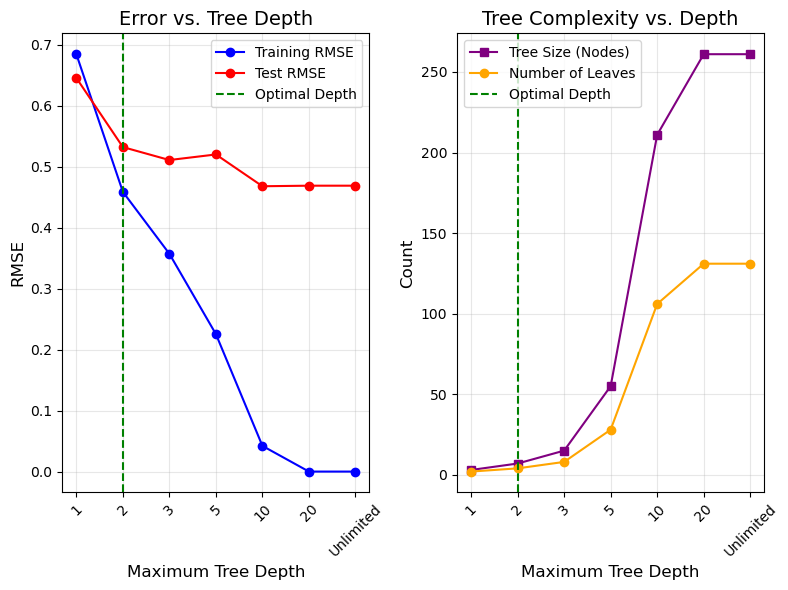

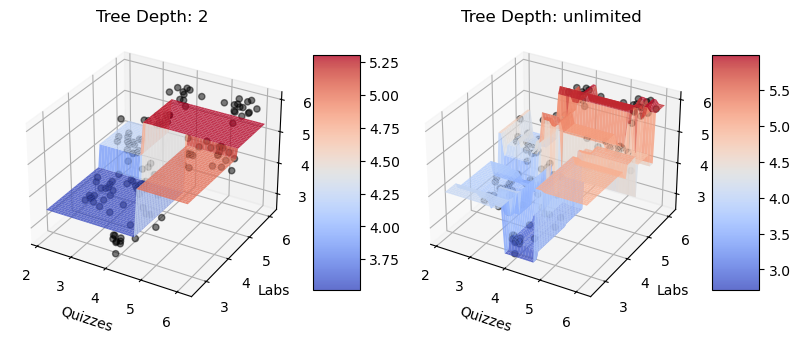

In [ ]:
# Train and evaluate trees with different depths 
max_depths = [1, 2, 3, 5, 10, 20, None]  # None means unlimited depth
train_scores = []
test_scores = []
tree_sizes = []
leaf_counts = []

# Store the models 
models = {}

for depth in max_depths:
    # Create and train the regression tree
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    # Store the model
    depth_key = str(depth) if depth is not None else "unlimited"
    models[depth_key] = tree
    
    # Calculate the tree size (number of nodes)
    n_nodes = tree.tree_.node_count
    tree_sizes.append(n_nodes)
    
    # Calculate number of leaves
    n_leaves = tree.tree_.node_count - np.sum(tree.tree_.children_left != -1)
    leaf_counts.append(n_leaves)
    
    # Make predictions and calculate RMSE
    y_train_pred = tree.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_scores.append(train_rmse)
    
    y_test_pred = tree.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_scores.append(test_rmse)
    
    # Print the results
    #depth_str = str(depth) if depth is not None else "Unlimited"
    #print(f"\nDepth: {depth_str}")
    #print(f"Number of nodes: {n_nodes}")
    #print(f"Number of leaves: {n_leaves}")
    #print(f"Training RMSE: {train_rmse:.4f}")
    #print(f"Test RMSE: {test_rmse:.4f}")

# Plot the results to show overfitting
plt.figure(figsize=(8, 6))

depth_labels = [str(d) if d is not None else "Unlimited" for d in max_depths]

plt.subplot(1, 2, 1)
plt.plot(range(len(max_depths)), train_scores, 'o-', label='Training RMSE', color='blue')
plt.plot(range(len(max_depths)), test_scores, 'o-', label='Test RMSE', color='red')
plt.axvline(x=1, color='green', linestyle='--', label='Optimal Depth')
plt.xlabel('Maximum Tree Depth', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Error vs. Tree Depth', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(len(max_depths)), depth_labels, rotation=45)

plt.subplot(1, 2, 2)
plt.plot(range(len(max_depths)), tree_sizes, 's-', label='Tree Size (Nodes)', color='purple')
plt.plot(range(len(max_depths)), leaf_counts, 'o-', label='Number of Leaves', color='orange')
plt.axvline(x=1, color='green', linestyle='--', label='Optimal Depth')
plt.xlabel('Maximum Tree Depth', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Tree Complexity vs. Depth', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(len(max_depths)), depth_labels, rotation=45)

plt.tight_layout()
plt.savefig('overfitting_curves.png', dpi=300)


#  visualize decision boundaries
# deeper trees create more complex boundaries
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points for visualization
x_min, x_max = X['Quizzes'].min() - 0.1, X['Quizzes'].max() + 0.1
y_min, y_max = X['Labs'].min() - 0.1, X['Labs'].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                     np.linspace(y_min, y_max, 50))

# Create 3D plots for different tree depths
depths_to_plot = ["2", "unlimited"]  # Compare optimal vs overfitting
fig = plt.figure(figsize=(8, 5))

for i, depth in enumerate(depths_to_plot):
    # Make predictions on the grid points
    grid_points = pd.DataFrame({'Quizzes': xx.ravel(), 'Labs': yy.ravel()})
    Z = models[depth].predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Plot the surface
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, alpha=0.8, linewidth=0)
    
    # Plot the training points
    ax.scatter(X_train['Quizzes'], X_train['Labs'], y_train, c='black', s=20, alpha=0.5)
    
    ax.set_xlabel('Quizzes')
    ax.set_ylabel('Labs')
    ax.set_zlabel('Final Grade')
    ax.set_title(f"Tree Depth: {depth}")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.savefig('decision_surfaces.png', dpi=300)

print("\nOptimal tree depth based on test error: 2")
print("This demonstrates overfitting: as the tree depth increases beyond the optimal value:")
print("- Training error continues to decrease")
print("- Test error starts increasing")
print("- Tree complexity (nodes and leaves) grows")
print("\nPruning (limiting tree depth) helps prevent overfitting!")

Now we demonstrate different pre-pruning methods. We can see the following in the figures: As tree depth increases (less pruning):
 - Training error continues to decrease
 - Test error decreases initially, then increases (overfitting)
 - Tree complexity (nodes and leaves) grows.
   
As min_samples_leaf increases (more pruning):
 - Both training and test errors initially decrease, then increase
 - Tree complexity decreases.



==== Pre-pruning with max_depth ====
max_depth=1: Nodes=3, Leaves=2, Train RMSE=0.6844, Test RMSE=0.6454
max_depth=2: Nodes=7, Leaves=4, Train RMSE=0.4586, Test RMSE=0.5320
max_depth=3: Nodes=15, Leaves=8, Train RMSE=0.3571, Test RMSE=0.5108
max_depth=4: Nodes=29, Leaves=15, Train RMSE=0.2948, Test RMSE=0.4043
max_depth=5: Nodes=55, Leaves=28, Train RMSE=0.2254, Test RMSE=0.5200
max_depth=10: Nodes=211, Leaves=106, Train RMSE=0.0421, Test RMSE=0.4679
max_depth=15: Nodes=261, Leaves=131, Train RMSE=0.0000, Test RMSE=0.4688
max_depth=20: Nodes=261, Leaves=131, Train RMSE=0.0000, Test RMSE=0.4688
max_depth=Unlimited: Nodes=261, Leaves=131, Train RMSE=0.0000, Test RMSE=0.4688

 Pre-pruning with min_samples_leaf 
min_samples_leaf=1: Nodes=261, Leaves=131, Train RMSE=0.0000, Test RMSE=0.4688
min_samples_leaf=2: Nodes=111, Leaves=56, Train RMSE=0.1508, Test RMSE=0.4572
min_samples_leaf=5: Nodes=43, Leaves=22, Train RMSE=0.2622, Test RMSE=0.4278
min_samples_leaf=10: Nodes=17, Leaves=9, Train 

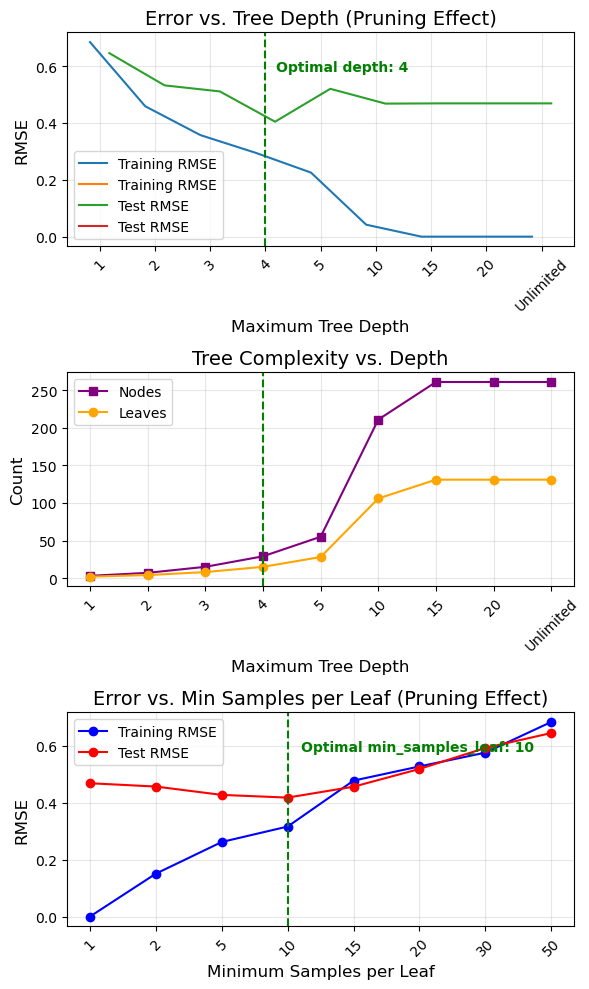

In [35]:

# 1. Compare different max_depth values (pre-pruning)
print("\n==== Pre-pruning with max_depth ====")
depths = [1, 2, 3, 4, 5, 10, 15, 20, None]  # None means unlimited
depth_train_scores = []
depth_test_scores = []
depth_nodes = []
depth_leaves = []

for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    # Calculate metrics
    n_nodes = tree.tree_.node_count
    n_leaves = n_nodes - np.sum(tree.tree_.children_left != -1)
    
    y_train_pred = tree.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    y_test_pred = tree.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Store results
    depth_nodes.append(n_nodes)
    depth_leaves.append(n_leaves)
    depth_train_scores.append(train_rmse)
    depth_test_scores.append(test_rmse)
    
    # Display results
    depth_str = str(depth) if depth is not None else "Unlimited"
    print(f"max_depth={depth_str}: Nodes={n_nodes}, Leaves={n_leaves}, Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}")

# 2. Compare different min_samples_leaf values (pre-pruning)
print("\n Pre-pruning with min_samples_leaf ")
min_samples = [1, 2, 5, 10, 15, 20, 30, 50]
leaf_train_scores = []
leaf_test_scores = []
leaf_nodes = []
leaf_leaves = []

for min_leaf in min_samples:
    tree = DecisionTreeRegressor(min_samples_leaf=min_leaf, random_state=42)
    tree.fit(X_train, y_train)
    
    # Calculate metrics
    n_nodes = tree.tree_.node_count
    n_leaves = n_nodes - np.sum(tree.tree_.children_left != -1)
    
    y_train_pred = tree.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    y_test_pred = tree.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Store results
    leaf_nodes.append(n_nodes)
    leaf_leaves.append(n_leaves)
    leaf_train_scores.append(train_rmse)
    leaf_test_scores.append(test_rmse)
    
    # Display results
    print(f"min_samples_leaf={min_leaf}: Nodes={n_nodes}, Leaves={n_leaves}, Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}")

# visualizations that demonstrate pruning effects
plt.figure(figsize=(6, 10))

# 1. Depth pruning 
plt.subplot(3, 1, 1)
width = 0.35
depth_indices = np.arange(len(depths))
depth_labels = [str(d) if d is not None else "Unlimited" for d in depths]

plt.plot(depth_indices - width/2, depth_train_scores, width, label='Training RMSE')
plt.plot(depth_indices + width/2, depth_test_scores, width, label='Test RMSE')
plt.xlabel('Maximum Tree Depth', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Error vs. Tree Depth (Pruning Effect)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(depth_indices, depth_labels, rotation=45)

optimal_depth_index = np.argmin(depth_test_scores)
plt.axvline(x=optimal_depth_index, color='green', linestyle='--')
plt.text(optimal_depth_index+0.2, max(depth_test_scores)*0.9, 
         f'Optimal depth: {depths[optimal_depth_index]}', 
         color='green', fontweight='bold')

# 2. Tree complexity vs depth
plt.subplot(3, 1, 2)
plt.plot(depth_indices, depth_nodes, 's-', label='Nodes', color='purple')
plt.plot(depth_indices, depth_leaves, 'o-', label='Leaves', color='orange')
plt.axvline(x=optimal_depth_index, color='green', linestyle='--')
plt.xlabel('Maximum Tree Depth', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Tree Complexity vs. Depth', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(depth_indices, depth_labels, rotation=45)

# 3. min_samples_leaf pruning 
plt.subplot(3, 1, 3)
leaf_indices = np.arange(len(min_samples))

plt.plot(leaf_indices, leaf_train_scores, 'o-', label='Training RMSE', color='blue')
plt.plot(leaf_indices, leaf_test_scores, 'o-', label='Test RMSE', color='red')
plt.xlabel('Minimum Samples per Leaf', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Error vs. Min Samples per Leaf (Pruning Effect)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(leaf_indices, min_samples, rotation=45)

optimal_leaf_index = np.argmin(leaf_test_scores)
plt.axvline(x=optimal_leaf_index, color='green', linestyle='--')
plt.text(optimal_leaf_index+0.2, max(leaf_test_scores)*0.9, 
         f'Optimal min_samples_leaf: {min_samples[optimal_leaf_index]}', 
         color='green', fontweight='bold')

plt.tight_layout()
plt.savefig('pruning_visualization.png', dpi=300)


# Annotate the "sweet spot" region
optimal_depth_nodes = depth_nodes[optimal_depth_index]
optimal_depth_rmse = depth_test_scores[optimal_depth_index]
plt.annotate('Sweet Spot\n(Best Trade-off)', 
             xy=(optimal_depth_nodes, optimal_depth_rmse),
             xytext=(optimal_depth_nodes+50, optimal_depth_rmse-0.05),
             arrowprops=dict(facecolor='green', shrink=0.05, width=2),
             fontsize=12, color='green', fontweight='bold')

plt.tight_layout()
plt.savefig('pruning_tradeoff.png', dpi=300)


print(f"   - Optimal max_depth: {depths[optimal_depth_index]}")
print(f"   - Optimal min_samples_leaf: {min_samples[optimal_leaf_index]}")

Now we will demonstrate rondom forest.

Pass rate in original data: 68.8%
Augmented dataset size: 176
Pass rate in augmented data: 65.3%
Training set size: 132
Test set size: 44
n_estimators=1, OOB Error: 0.5227
n_estimators=5, OOB Error: 0.1742
n_estimators=10, OOB Error: 0.1364
n_estimators=20, OOB Error: 0.1212
n_estimators=50, OOB Error: 0.1364
n_estimators=100, OOB Error: 0.1288


/Users/alisarupenyan/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/alisarupenyan/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n_estimators=200, OOB Error: 0.1212

Final Random Forest Model (n_estimators=100)
Accuracy: 0.8409
OOB Score: 0.8712

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76        15
         1.0       0.87      0.90      0.88        29

    accuracy                           0.84        44
   macro avg       0.83      0.81      0.82        44
weighted avg       0.84      0.84      0.84        44



/var/folders/zc/7515kqlj3r90350hdc7p7yqw0000gq/T/ipykernel_89589/3679757112.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
/Users/alisarupenyan/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



Threshold values from important trees:

Tree 1:
  Quizzes thresholds: 3.02, 3.13, 3.17, 3.41, 3.52, 3.92, 4.01, 4.53
  Labs thresholds: 3.04, 3.22, 4.01, 4.07, 4.12, 4.42, 4.67, 4.78, 4.85

Tree 2:
  Quizzes thresholds: 2.53, 3.01, 3.21, 3.23, 3.33, 3.39, 3.61, 3.83, 3.94, 3.97, 4.02, 4.15, 4.60
  Labs thresholds: 4.20, 4.45, 4.47, 4.79, 4.95, 4.96, 5.42

Tree 3:
  Quizzes thresholds: 3.02, 3.07, 3.14, 3.32, 3.40, 4.60
  Labs thresholds: 3.03, 4.02, 4.12, 4.42, 4.64, 4.78


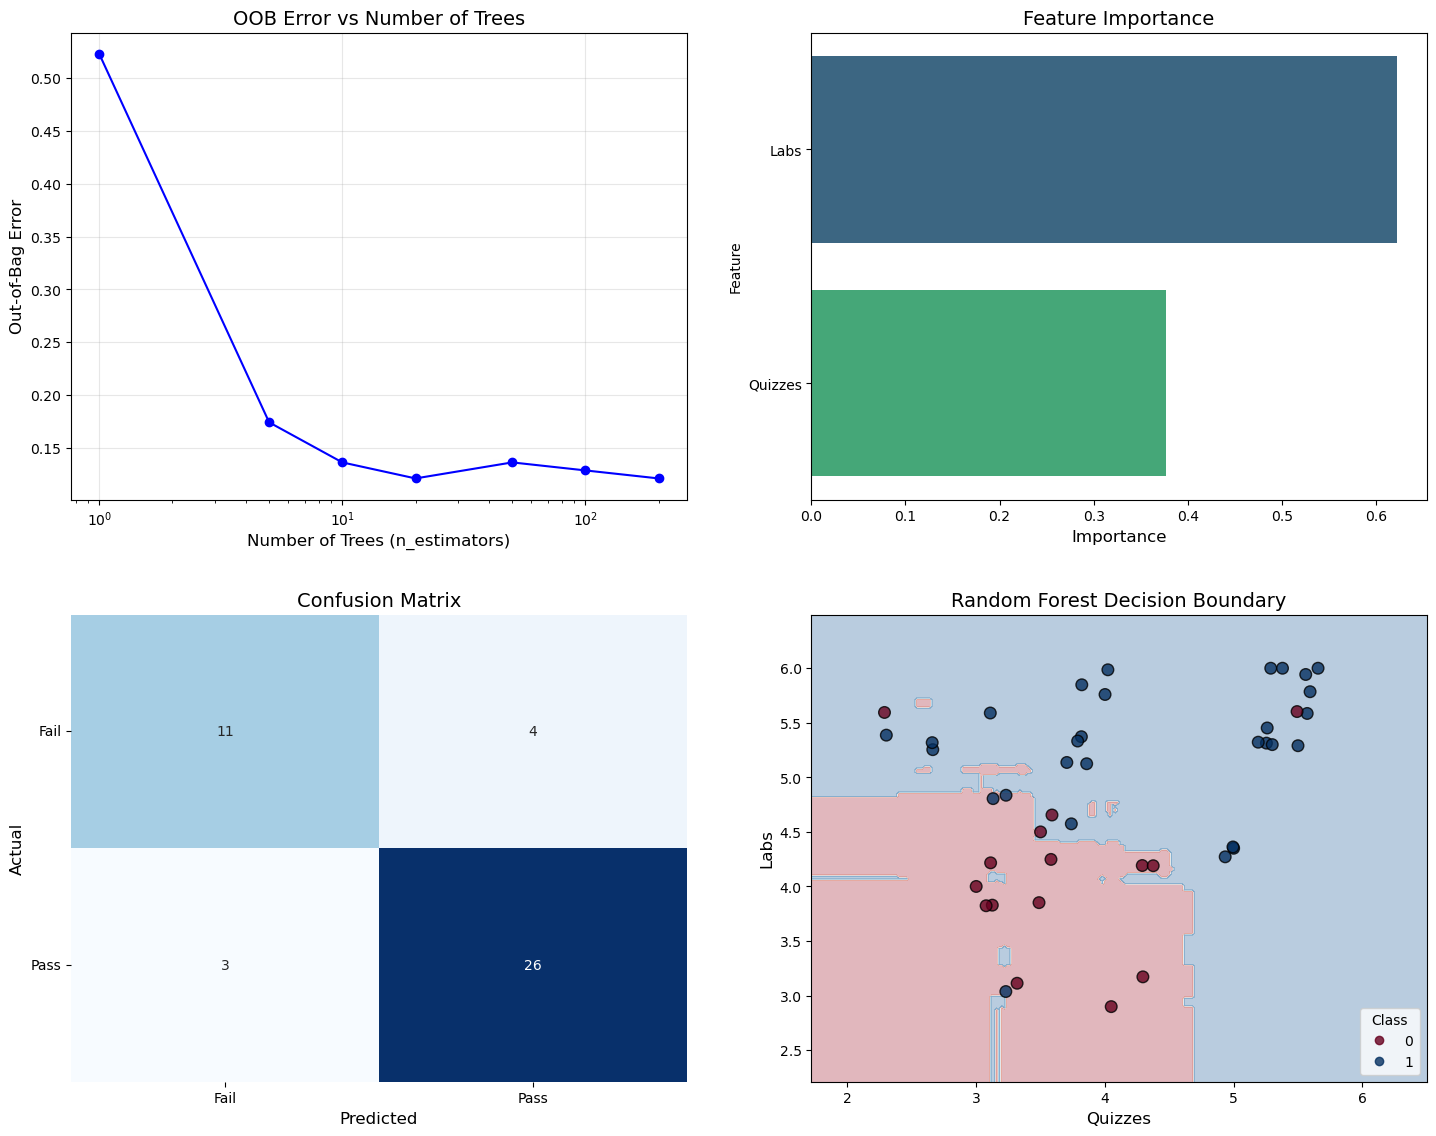

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Create the original dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create a binary pass/fail target (passing grade >= 4.0)
df['Pass'] = (df['Final'] >= 4.0).astype(int)
print(f"Pass rate in original data: {df['Pass'].mean()*100:.1f}%")

# Augment data by adding noise to create more points
np.random.seed(42)
augmented_data = []

# First, include original data points
for i, row in df.iterrows():
    augmented_data.append({
        'Quizzes': row['Quizzes'],
        'Labs': row['Labs'],
        'Final': row['Final'],
        'Pass': row['Pass']
    })

# Then add 10 variations with noise for each original point
for i, row in df.iterrows():
    for j in range(10):
        # Create noise for each feature
        noise_quiz = np.random.normal(0, 0.2)
        noise_lab = np.random.normal(0, 0.2)
        noise_final = np.random.normal(0, 0.2)
        
        # Add noise and clip to range [2, 6]
        new_quiz = min(max(row['Quizzes'] + noise_quiz, 2), 6)
        new_lab = min(max(row['Labs'] + noise_lab, 2), 6)
        new_final = min(max(row['Final'] + noise_final, 2), 6)
        
        # Determine pass/fail based on noisy final grade
        new_pass = 1 if new_final >= 4.0 else 0
        
        # Add to augmented data
        augmented_data.append({
            'Quizzes': new_quiz,
            'Labs': new_lab,
            'Final': new_final,
            'Pass': new_pass
        })

# Convert augmented data to DataFrame
df_aug = pd.DataFrame(augmented_data)
print(f"Augmented dataset size: {len(df_aug)}")
print(f"Pass rate in augmented data: {df_aug['Pass'].mean()*100:.1f}%")

# Split the data into training and test sets
X = df_aug[['Quizzes', 'Labs']]
y = df_aug['Pass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=52)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Train Random Forest with different numbers of estimators to visualize OOB error
n_estimators_range = [1, 5, 10, 20, 50, 100, 200]
oob_errors = []

for n_est in n_estimators_range:
    # Create and train Random Forest with OOB score enabled
    rf = RandomForestClassifier(n_estimators=n_est, 
                              oob_score=True, 
                              random_state=42)
    rf.fit(X_train, y_train)
    
    # Calculate OOB error
    oob_error = 1 - rf.oob_score_
    oob_errors.append(oob_error)
    
    print(f"n_estimators={n_est}, OOB Error: {oob_error:.4f}")

# Train the final model with a good number of trees
rf_final = RandomForestClassifier(n_estimators=100, 
                                oob_score=True,
                                random_state=42)
rf_final.fit(X_train, y_train)

# Calculate feature importances
feature_importances = rf_final.feature_importances_
feature_names = X.columns

# Make predictions
y_pred = rf_final.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Random Forest Model (n_estimators=100)")
print(f"Accuracy: {accuracy:.4f}")
print(f"OOB Score: {rf_final.oob_score_:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create visualizations
plt.figure(figsize=(15, 12))

# 1. Plot OOB error vs number of trees
plt.subplot(2, 2, 1)
plt.plot(n_estimators_range, oob_errors, 'o-', color='blue')
plt.xlabel('Number of Trees (n_estimators)', fontsize=12)
plt.ylabel('Out-of-Bag Error', fontsize=12)
plt.title('OOB Error vs Number of Trees', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Log scale for better visualization

# 2. Feature importance plot
plt.subplot(2, 2, 2)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()

# 3. Confusion matrix
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
classes = ['Fail', 'Pass']
plt.xticks(np.arange(len(classes))+0.5, classes)
plt.yticks(np.arange(len(classes))+0.5, classes, rotation=0)

# 4. Decision boundary visualization
plt.subplot(2, 2, 4)
# Create a meshgrid to visualize the decision boundary
h = 0.02  # Step size
x_min, x_max = X['Quizzes'].min() - 0.5, X['Quizzes'].max() + 0.5
y_min, y_max = X['Labs'].min() - 0.5, X['Labs'].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions on the meshgrid
Z = rf_final.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

# Plot the training points
scatter = plt.scatter(X_test['Quizzes'], X_test['Labs'], c=y_test, 
               cmap=plt.cm.RdBu, edgecolor='k', s=70, alpha=0.8)
plt.xlabel('Quizzes', fontsize=12)
plt.ylabel('Labs', fontsize=12)
plt.title('Random Forest Decision Boundary', fontsize=14)
legend1 = plt.legend(*scatter.legend_elements(), title="Class", loc="lower right")

plt.tight_layout(pad=3.0)
plt.savefig('random_forest_visualization.png', dpi=300)

# Show the most important threshold values learned by the random forest
print("\nThreshold values from important trees:")
for i, tree in enumerate(rf_final.estimators_[:3]):  # Look at first 3 trees
    print(f"\nTree {i+1}:")
    tree_thresholds = []
    
    # Get thresholds for each node
    for node_id in range(tree.tree_.node_count):
        # Only look at non-leaf nodes
        if tree.tree_.children_left[node_id] != -1:
            feature_id = tree.tree_.feature[node_id]
            threshold = tree.tree_.threshold[node_id]
            feature_name = X.columns[feature_id]
            tree_thresholds.append((feature_name, threshold))
    
    # Print unique thresholds for each feature
    for feature in X.columns:
        thresholds = sorted(set([t[1] for t in tree_thresholds if t[0] == feature]))
        if thresholds:
            print(f"  {feature} thresholds: {', '.join([f'{t:.2f}' for t in thresholds])}")